https://www.kaggle.com/code/nathanbitu/top-12-my-approach-to-house-price-regression

overview:

1) Class to perform data prepreocssing:
    a) read from csv
    b) calculate % of missing value per feature
    c) fill NA with column specific instructions (could be improved using df.get_dtypes(include='numeric'/exclude='numeric))
    d) returns imputed dataset for EDA
    e) log transforms the target variable
    f) one hot encodes

https://www.kaggle.com/code/gomes555/xgboost-bayes-opt-with-tidymodels

1) remove features with high pct of missing value
2) log transform the independent variable, visualize qq plot before/after

### 0. Dependencies :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### 1. Import data:

In [2]:
train_data = pd.read_csv('./res/train.csv')
test_data = pd.read_csv('./res/test.csv')

### 2. Clean, encode data:

#### 2.1 Visualize

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_14744/2860196287.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')
/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_14744/2860196287.py:15: UserWarning: The palette list has more values (81) than needed (19), which may not be intended.
  sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')


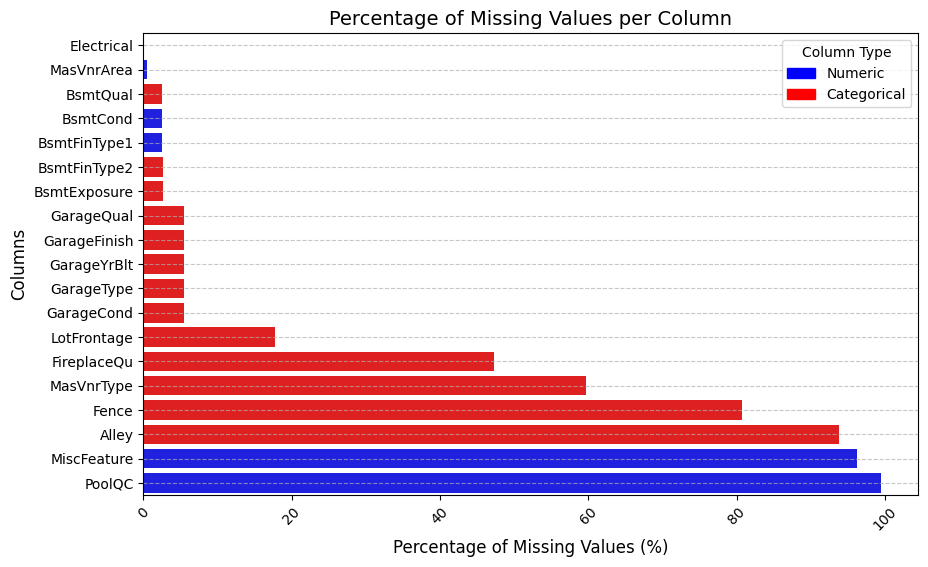

In [3]:
# Calculate the percentage of missing values per column
missing_percentage = train_data.isnull().mean().sort_values() * 100
missing_percentage = missing_percentage[missing_percentage>0]
# sub_train = train_data[[col for col in train_data.columns if col in missing_percentage.index]]

# Determine column types
column_types = train_data.dtypes.apply(lambda dtype: 'Numeric' if np.issubdtype(dtype, np.number) else 'Categorical')

# Assign colors based on column types
color_map = {'Numeric': 'blue', 'Categorical': 'red'}
bar_colors = [color_map[col_type] for col_type in column_types]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')
plt.title("Percentage of Missing Values per Column", fontsize=14)
plt.xlabel("Percentage of Missing Values (%)", fontsize=12)
plt.ylabel("Columns", fontsize=12)
plt.xticks(rotation=45)
# plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_map.values()]
labels = list(color_map.keys())
plt.legend(handles, labels, title="Column Type")

plt.show()


#### 2.2 Fill feature NAs

In [4]:
# Fill in the NAs depending on feature type: 'None' if categorical, 0 if numerics
for type, col in zip(column_types, column_types.index):
    if col != 'SalePrice':
        if type == 'Categorical':
            train_data.loc[:, [col]] = train_data[col].fillna('None')
            test_data.loc[:, [col]] = test_data[col].fillna('None')
        else:
            train_data.loc[:, [col]] = train_data[col].fillna(0)
            test_data.loc[:, [col]] = test_data[col].fillna(0)

#### 2.3 Target variable distribution normalization

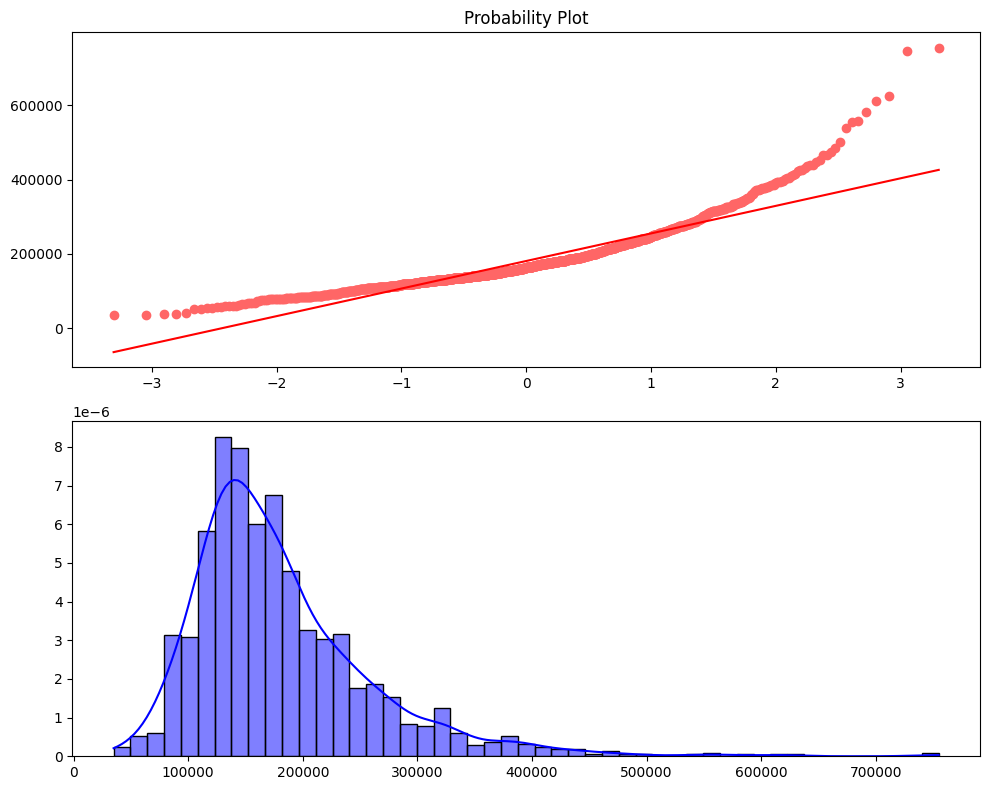

In [5]:
# Create subplots
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Histogram + Density
ax1 = fig.add_subplot(gs[1, :])
sns.histplot(train_data['SalePrice'], kde=True, stat="density", color="blue", edgecolor="black", ax=ax1)
ax1.set(xlabel="", ylabel="")

# QQ Plot
ax3 = fig.add_subplot(gs[0, :])
stats.probplot(train_data['SalePrice'], dist="norm", plot=ax3)
ax3.get_lines()[0].set_color('#FF6666')  # Customize QQ line
ax3.set(xlabel="", ylabel="")

# Adjust layout
plt.tight_layout()
plt.show()

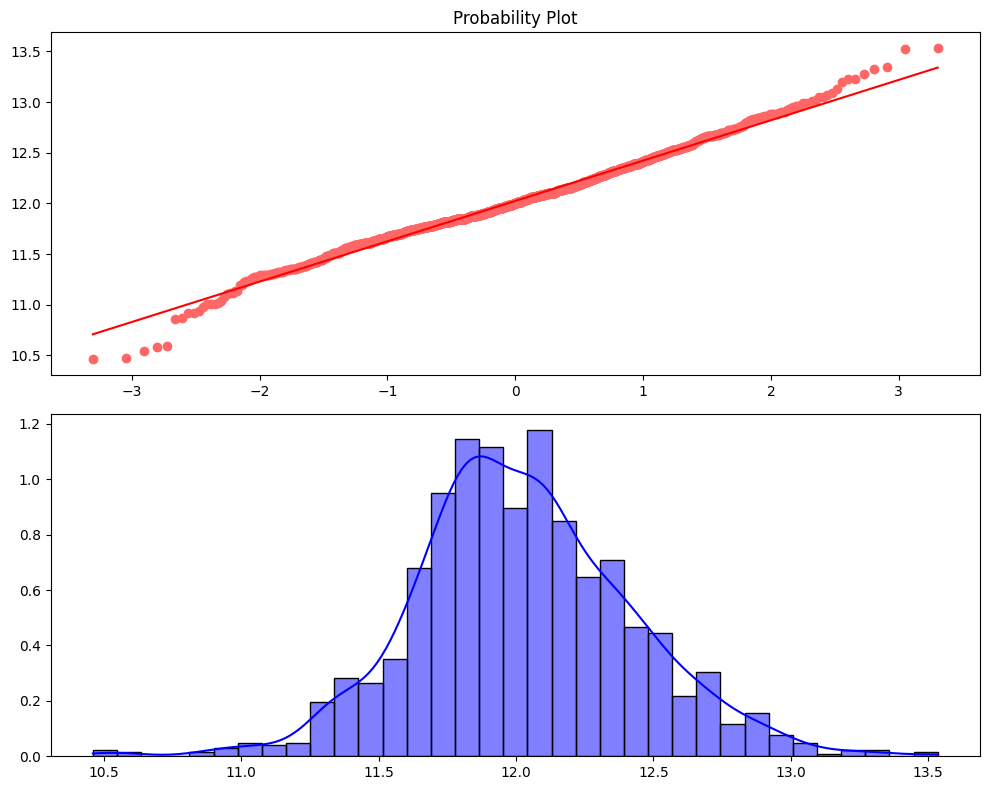

In [6]:
transformed_target = np.log(train_data['SalePrice'])

# Create subplots
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Histogram + Density
ax1 = fig.add_subplot(gs[1, :])
sns.histplot(transformed_target, kde=True, stat="density", color="blue", edgecolor="black", ax=ax1)
ax1.set(xlabel="", ylabel="")

# QQ Plot
ax3 = fig.add_subplot(gs[0, :])
stats.probplot(transformed_target, dist="norm", plot=ax3)
ax3.get_lines()[0].set_color('#FF6666')  # Customize QQ line
ax3.set(xlabel="", ylabel="")

# Adjust layout
plt.tight_layout()
plt.show()

It looks better after a log transform, let's keep it this way

In [7]:
train_data.loc[:,['SalePrice']] = transformed_target

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_14744/3388291937.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.24769432 12.10901093 12.31716669 ... 12.49312952 11.86446223
 11.90158345]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[:,['SalePrice']] = transformed_target


#### 2.3 Prepare te dataset for training and testing

ideally, we need to perform in order:
- select a number K of folds for cross validation
- operate the train/test split on each fold
- transform the fold data accoding to the PrepareData operations
- fit a Ridge+XGBoost ensemble model to the fold

doing this multiples time to optimise the model hyperparamaters, using a RandomSearchCV !

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y):
        return self

    def transform(self, X):
        # print(X.columns)
        if self.column_name in X.columns:
            return X.drop(columns = self.column_name, axis = 1)
        return X

class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, name):
        self.name = name
    
    def transform(self, X):
        print(self.name)
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class KNNImputerWithLabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = KNNImputer(weights='distance')
        self.encoders = {}

    def fit(self, X, y=None):
        X_encoded = self._encode_labels(X)
        print('[KNNImpute] running LE, done encoding')
        self.imputer.fit(X_encoded)
        print('[KNNImpute] running fit, done imputing')
        return self

    def transform(self, X):
        X_encoded = self._encode_labels(X)
        X_imputed = self.imputer.transform(X_encoded)
        print('[KNNImpute] running transform, done KNN')
        return self._decode_labels(X_imputed)

    def _encode_labels(self, X):
        """Encodes categorical features using LabelEncoder."""
        X_encoded = X.copy()
        for column in X_encoded.columns:
            le = LabelEncoder()
            X_encoded[column] = le.fit_transform(X_encoded[column])
            self.encoders[column] = le
        return X_encoded

    def _decode_labels(self, X_imputed):
        """Inverse transforms the encoded features back to their original categories."""
        X_decoded = pd.DataFrame(X_imputed, columns=self.encoders.keys())
        for column, le in self.encoders.items():
            X_decoded[column] = np.round(X_decoded[column]).astype(int)  # Ensure integers for inverse_transform
            X_decoded[column] = le.inverse_transform(X_decoded[column])
        return X_decoded



In [9]:
target = 'SalePrice'
y = train_data[target]
X = train_data[[col for col in train_data if col != target]]

numerical_features = [col for col in X.columns if (np.issubdtype(X[col].dtype, np.number) and col != target)]
categorical_features = [col for col in X.columns if (col not in numerical_features and col != target)]

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

numeric_transformer = Pipeline(steps=[
    ('clean', DropColumn(column_name='Id')),
    ('dbg_c', Debug('done_num_cleaning')),
    ('impute', SimpleImputer(strategy='mean')),
    ('dbg_i', Debug('done_num_imputingg')),
    ('log_transform', FunctionTransformer(np.log1p, validate = True)),
    ('dbg_l', Debug('done_log_transform')),
    ('scale', StandardScaler()),
    ('dbg_s', Debug('done_num_scaling')),
])

categorical_transformer = Pipeline(steps=[
    ('clean', DropColumn(column_name='Id')),
    ('dbg_c', Debug('done_cat_cleaning')),
    ('impute', KNNImputerWithLabelEncoding()),
    ('dbg_i', Debug('done_cat_imputingg')),
    ('one_hot_encode', OneHotEncoder(handle_unknown='ignore')),
    # ('one_hot_encode', DebugOneHot()),
    ('dbg_o', Debug('done_ohe')),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('ft_selec', Ridge()),
    # ('xgb', XGBRegressor())
])

kf = KFold(n_splits = 5, shuffle = True, random_state=7)

scores = cross_val_score(pipeline, X, y, cv = kf, scoring='neg_mean_squared_error', error_score='raise')
print("Mean Squared Error (CV):", -np.mean(scores))

done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
do

No data leakage witht the One Hot encoding as the cross_val_score function calls .fit() on the pipeline and then .transform() on respectively the train and the test set that it is fed through the cv= kf arguement.

In [24]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from skopt import BayesSearchCV, space


stacking_model = StackingRegressor(
    estimators = [('pl', pipeline)],
    final_estimator=XGBRegressor(),
) 

# Define the parameter grid for hyperparameter tuning
# param_distributions = {
#     # 'ft_selec__alpha': uniform(0.01, 10),  # Ridge regularization strength
#     # 'model__n_estimators': randint(50, 500),  # Number of trees for XGBRegressor
#     # 'model__learning_rate': uniform(0.01, 0.2),  # Learning rate for XGBRegressor
#     # 'model__max_depth': randint(3, 10),  # Max depth of trees for XGBRegressor
#     # 'model__colsample_bytree': uniform(0.3, 0.7),  # Column sampling for XGBRegressor
#     'final_estimator__n_estimators': randint(50, 500),  # Number of trees for XGBRegressor
#     'final_estimator__learning_rate': uniform(0.01, 0.2),  # Learning rate for XGBRegressor
#     'final_estimator__max_depth': randint(3, 10),  # Max depth of trees for XGBRegressor
#     'final_estimator__colsample_bytree': uniform(0.3, 0.7),  # Column sampling for XGBRegressor
# }

# RandomizedSearchCV setup
# random_search = RandomizedSearchCV(
#     estimator=stacking_model,
#     param_distributions=param_distributions,
#     n_iter=50,  # Number of parameter settings sampled
#     cv=kf,  # Cross-validation splits
#     scoring='neg_mean_squared_error',
#     random_state=7,
#     verbose=1,
#     error_score='raise',
#     n_jobs=-1  # Use all processors
# )

# Fit the RandomizedSearchCV object
# random_search.fit(X, y)
# Display best parameters and score
# print("Best parameters:", random_search.best_params_)
# print("Best CV score (MSE):", -random_search.best_score_)

# BayesianOptimisation

search_space = {
    'final_estimator__max_depth': (0, 50),
    'final_estimator__n_estimators': (50, 500),
    'final_estimator__learning_rate': (0.01, 1.0, 'log-uniform'),
    'final_estimator__gamma': (1e-9, 0.5, 'log-uniform'),
    'final_estimator__scale_pos_weight': (1e-6, 500, 'log-uniform'),
    'final_estimator__colsample_bytree': (0.1, 0.9)
}

bayes_opt = BayesSearchCV(
    estimator=stacking_model,
    search_spaces=search_space,
    cv = kf,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=1,
    n_iter=150,
)

# fit the BayesSearchCV
bayes_opt.fit(X, y)

# Display best parameters and score
print("Best parameters:", bayes_opt.best_params_)
print("Best CV score (MSE):", -bayes_opt.best_score_)





Fitting 5 folds for each of 1 candidates, totalling 5 fits
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
d

/Users/jordanbonil/Documents/source/kaggle/house_prices/.tf_venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
d

/Users/jordanbonil/Documents/source/kaggle/house_prices/.tf_venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running LE, done encoding
[KNNImpute] running fit, done imputing
[KNNImpute] running transform, done KNN
done_cat_imputingg
done_ohe
done_num_cleaning
done_num_imputingg
done_log_transform
done_num_scaling
done_cat_cleaning
[KNNImpute] running transform, done KNN
do

In [ ]:
# We shall make a class 

class PrepareData():
    def __init__(self, df: pd.DataFrame, target: str, is_test:bool = False, ohe:OneHotEncoder = None):
        self.data = df.copy()
        self.target = target
        self.is_test = is_test
        self.ohe = ohe
    
    def clean(self):
        self.data.drop(columns='Id', inplace=True, axis = 1)

    def identify_feature_types(self):
        self.numeric_features = [col for col in self.data.columns if (np.issubdtype(self.data[col].dtype, np.number) and col != self.target)]
        self.categorical_features = [col for col in self.data.columns if (col not in self.numeric_features and col != self.target)]

    def log_transform(self):
        # log transforms all numeric variables except the target
        self.data.loc[:, self.numeric_features] = np.log(1 + self.data.loc[:, self.numeric_features])

    def standardize(self):
        self.data.loc[:, self.numeric_features] = StandardScaler().fit_transform(self.data.loc[:, self.numeric_features])

    def fit_transform(self):
        ...
        pass
    
    def one_hot_encode(self):
        if self.is_test:
            ohe = self.ohe  # Ensure output is not sparse
            new_ohe_cat_features = ohe.transform(self.data[self.categorical_features])
        else:
            ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            new_ohe_cat_features = ohe.fit_transform(self.data[self.categorical_features])
        
        # Convert the one-hot encoded features into a DataFrame with proper column names
        ohe_feature_names = ohe.get_feature_names_out(self.categorical_features)
        ohe_df = pd.DataFrame(new_ohe_cat_features, columns=ohe_feature_names, index=self.data.index)
        
        # Drop the original categorical columns
        self.data.drop(columns=self.categorical_features, axis=1, inplace=True)
        
        # Concatenate the one-hot encoded DataFrame to the original DataFrame
        self.data = pd.concat([self.data, ohe_df], axis=1)
        if not self.is_test:
            return ohe
    
    def get_df(self):
        return self.data

In [ ]:
## Train
train_pipe = PrepareData(train_data, target = 'SalePrice')

train_pipe.clean()
train_pipe.identify_feature_types()
train_pipe.log_transform()
train_pipe.standardize()
ohe = train_pipe.one_hot_encode()

train = train_pipe.get_df()


## Test
test_pipe = PrepareData(test_data, target = 'SalePrice', is_test=True, ohe = ohe)

test_pipe.clean()
test_pipe.identify_feature_types()
test_pipe.log_transform()
test_pipe.standardize()
test_pipe.one_hot_encode()

test = test_pipe.get_df()

In [ ]:
feature_names

In [ ]:
test

In [ ]:
for col in train.columns:
    if col not in test.columns:
        print(col)